In [1]:
import torch
import gpytorch
from bilateral_kernel import BilateralKernel

In [2]:
kernel = BilateralKernel()

In [3]:
N_vals = torch.linspace(100, 10000000, 10).int().tolist()
D_vals = torch.linspace(1, 100, 10).int().tolist()

In [4]:
import timeit

N_vary = []
for N in N_vals:
    D = 1
    x = torch.randn(N, D)
    K = BilateralKernel()(x)
    v = torch.randn(N, 1)
    def matmul():
        return K @ v
    time = timeit.timeit(matmul , number=10)

    N_vary.append([N, D, time])

    del x
    del K
    del v
    del matmul

In [9]:
D_vary = []
for D in D_vals:
    N = 1000
    x = torch.randn(N, D)
    K = BilateralKernel()(x)
    v = torch.randn(N, 1)
    def matmul():
        return K @ v
    time = timeit.timeit(matmul , number=10)

    D_vary.append([N, D, time])

    del x
    del K
    del v
    del matmul

In [5]:
import pandas as pd

In [10]:
N_vary = pd.DataFrame(N_vary, columns=["N", "D", "Time"])
D_vary = pd.DataFrame(D_vary, columns=["N", "D", "Time"])

[Text(0.5, 1.0, 'Matmul (D=1)')]

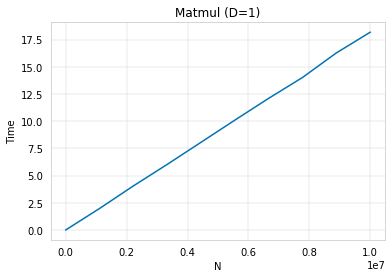

In [13]:
import seaborn as sns
ax = sns.lineplot(data=N_vary, x="N", y="Time")
ax.set(title="Matmul (D=1)")

Coefficients: 
 [2.16483509]


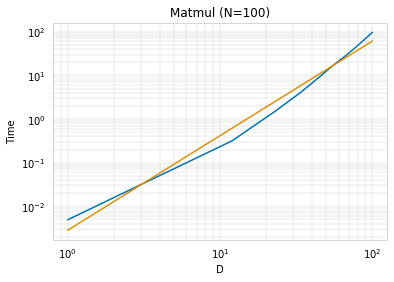

In [30]:
from sklearn.linear_model import LinearRegression
import numpy as np
regr = LinearRegression()
regr.fit(np.log(D_vary["D"].to_numpy()[:, None]), np.log(D_vary["Time"]))
print('Coefficients: \n', regr.coef_)
pred_time = regr.predict(np.log(D_vary["D"].to_numpy()[:, None]))

ax = sns.lineplot(data=D_vary, x="D", y="Time")
ax.set(title="Matmul (N=100)", xscale="log", yscale="log")
ax.plot(D_vary["D"].to_numpy(), np.exp(pred_time))